<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model
import scipy
import random
from tqdm import tqdm
import os

In [2]:
def plot_cm(y_true,y_pred,label,plot_precison_recall=False):
  """
  given y_true and y_pred and label(the names of the dataset)
  plot the confusion matric, precision matrix and recall matrix
  """
  print("\t\t %s \t\t"%(label))
  C = metrics.confusion_matrix(y_true,y_pred)
  plt.figure(figsize=(7,7))
  sns.heatmap(C,fmt='i',annot=True)
  plt.ylabel("TRUE LABEL")
  plt.xlabel("PREDICTED LABEL")
  plt.title('Confusion Matrix')
  plt.show()
  if plot_precision_recall:
    Precision = C/C.sum(axis=0) #Precision = TP/(TP+FP) sum of all values in a column will be 1
    C = metrics.confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(7,7))
    sns.heatmap(C,fmt='.3f',annot=True)
    plt.ylabel("TRUE LABEL")
    plt.xlabel("PREDICTED LABEL")
    plt.title('Precision Matrix')
    plt.show()

    Recall = (C.T/C.sum(axis=1)).T #Recall = TP/(TP+FN) sum of all values in a row will be 1
    C = metrics.confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(7,7))
    sns.heatmap(C,fmt='.3f',annot=True)
    plt.ylabel("TRUE LABEL")
    plt.xlabel("PREDICTED LABEL")
    plt.title('Recall Matrix')
    plt.show()



In [40]:
def plot_auc(y_true,y_pred,label):
  """
  Plots auc curve when y_true and y_pred are given
  """
  if (type(label)!=list) & (type(label)!=np.array):
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred)
    auc = metrics.roc_auc_score(y_true,y_pred)
    label = label+' AUC=%.3f'%(auc)
    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

  else:
    for y in y_pred:
      if (type(label)!=list) & (type(label)!=np.array):
        fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred)
        auc = metrics.roc_auc_score(y_true,y_pred)
        label = label+' AUC=%.3f'%(auc)
        #plotting tpr vs fpr
        sns.lineplot(fpr,tpr,label=label)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()


  


In [4]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [8]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[0] #Normal
test_file = file_path+file[1]
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

# Modeling

In [20]:
def find_best_params(model,params):
  """
  Funcion which implements Random Seacrh CV and return
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=-1,cv=10,random_state=420,)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

# Logistic Regression

In [18]:
model = linear_model.LogisticRegression()
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          'class_weight':'balanced'
          }


In [19]:
%%time
find_best_params(model,params)

The best auc score was 0.796
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'class_weight': 'n', 'C': 0.1}
The best estimator: LogisticRegression(C=0.1, class_weight='n', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=0.1, class_weight='n', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
model = linear_model.LogisticRegression(C=0.1, class_weight='n', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='n', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression Normal dataset"
plot_cm(y_val,y_pred,label)
plot_auc(y_val,y_pred,label)


		 Logisic Regression Normal dataset 		


ValueError: ignored

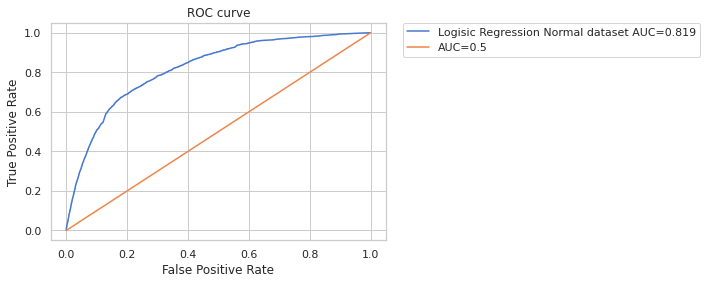

In [42]:
y_pred = model.predict_proba(X_train)[:,1]
plot_auc(y_train,y_pred,label)

In [17]:
 sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']